In [1]:
%matplotlib inline


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [4]:
!pip install git+https://github.com/albumentations-team/albumentations.git

  Cloning https://github.com/albumentations-team/albumentations.git to /tmp/pip-req-build-eu8x1cq0
  Running command git clone -q https://github.com/albumentations-team/albumentations.git /tmp/pip-req-build-eu8x1cq0
  Created wheel for albumentations: filename=albumentations-1.0.0-cp37-none-any.whl size=98151 sha256=01f70822feb8b288ffc3d32998d0f0d8324dc8f1e41801af2ec4a3c1d52e4a1a
  Stored in directory: /tmp/pip-ephem-wheel-cache-ngkp32s7/wheels/e2/85/3e/2a40fac5cc1f43ced656603bb2fca1327b30ec7de1b1b66517
Successfully built albumentations


In [5]:
# Reference https://albumentations.ai/docs/autoalbument/examples/cifar10/

class Cifar10SearchDataset(torchvision.datasets.CIFAR10):
    def __init__(self, root="~/data/cifar10", train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image, label

In [6]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

mean, std = (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)

train_transform = A.Compose(
    [
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=5, p=0.5),
        A.HorizontalFlip(p=0.5),
        A.CoarseDropout(max_holes = 1, max_height=16, max_width=16, min_holes = 1,
                        min_height=16, min_width=16,
                        fill_value=mean, mask_fill_value = None),
        A.Normalize(mean, std),
        A.ToGray(p=0.3),
        ToTensorV2(),
    ]
)

test_transform = A.Compose(
    [
        A.Normalize(mean, std),
        ToTensorV2(),
    ]
)

trainset = Cifar10SearchDataset(root='./data', train=True,
                                        download=True, transform=train_transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = Cifar10SearchDataset(root='./data', train=False,
                                       download=True, transform=test_transform)

testloader =torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  car   dog  bird  bird


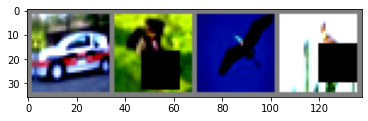

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [8]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [9]:
from model import Net

In [10]:
!pip install torchsummary
from torchsummary import summary

model = Net().to(device)  # Create model
summary(model, input_size=(3, 32, 32))  # Display model summary

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
            Conv2d-4           [-1, 32, 32, 32]           9,248
              ReLU-5           [-1, 32, 32, 32]               0
       BatchNorm2d-6           [-1, 32, 32, 32]              64
            Conv2d-7           [-1, 32, 32, 32]           9,248
              ReLU-8           [-1, 32, 32, 32]               0
       BatchNorm2d-9           [-1, 32, 32, 32]              64
        Dropout2d-10           [-1, 32, 32, 32]               0
           Conv2d-11           [-1, 32, 16, 16]           9,248
             ReLU-12           [-1, 32, 16, 16]               0
      BatchNorm2d-13           [-1, 32, 16, 16]              64
           Conv2d-14           [-1, 32,

3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [11]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

Train and Test functions

In [12]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    train_loss = 0
    correct = 0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        #loss = F.nll_loss(output, target)
        loss = criterion(output, target) 
        train_loss += loss.item()       
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')        
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

    train_loss /= len(train_loader.dataset)
    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        train_loss, correct, len(train_loader.dataset),
        100. * correct / len(train_loader.dataset)))
    return train_loss, 100.*correct/len(train_loader.dataset)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss, 100.*correct/len(test_loader.dataset)

4. Train the network
^^^^^^^^^^^^^^^^^^^^

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [13]:
# for epoch in range(2):  # loop over the dataset multiple times

#     running_loss = 0.0
#     for i, data in enumerate(trainloader, 0):
#         # get the inputs
#         inputs, labels = data

#         inputs, labels = inputs.to(device), labels.to(device)

#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = net(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         # print statistics
#         running_loss += loss.item()
#         if i % 2000 == 1999:    # print every 2000 mini-batches
#             print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss / 2000))
#             running_loss = 0.0

# print('Finished Training')

In [14]:
from torch.optim.lr_scheduler import StepLR,OneCycleLR

#model = Net().to(device)
lr = 0.01
#optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=lr)

train_loss_list = []
test_loss_list = []
train_accuracy_list=[]
test_accuracy_list=[]

#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = OneCycleLR(optimizer, max_lr=0.1,epochs=100,steps_per_epoch=len(trainloader))

for epoch in range(0, 100):
    print(f"Epoch {epoch}")
    # if(epoch % 4 == 0):
    #   lr = lr/10
    #   optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    #if(epoch==25):
    #  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.7)

    #if(epoch==40):
    #  optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
    
    train_loss,train_acc = train(model, device, trainloader, optimizer, epoch)
    #scheduler.step()
    test_loss,test_acc = test(model, device, testloader)

    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)

    train_accuracy_list.append(train_acc)
    test_accuracy_list.append(test_acc)

  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 0


loss=1.4136922359466553 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 32.29it/s]


Train set: Average loss: 0.0138, Accuracy: 16816/50000 (33.63%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -2.2230, Accuracy: 4482/10000 (44.82%)

Epoch 1


loss=1.4813681840896606 batch_id=390: 100%|██████████| 391/391 [00:11<00:00, 32.90it/s]


Train set: Average loss: 0.0116, Accuracy: 22675/50000 (45.35%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -2.7302, Accuracy: 5242/10000 (52.42%)

Epoch 2


loss=1.277536392211914 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 32.26it/s]


Train set: Average loss: 0.0106, Accuracy: 25220/50000 (50.44%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -3.2565, Accuracy: 5728/10000 (57.28%)

Epoch 3


loss=1.3047806024551392 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 32.45it/s]


Train set: Average loss: 0.0096, Accuracy: 27601/50000 (55.20%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -4.0484, Accuracy: 6241/10000 (62.41%)

Epoch 4


loss=1.0037630796432495 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 32.48it/s]


Train set: Average loss: 0.0090, Accuracy: 29369/50000 (58.74%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -4.1257, Accuracy: 6525/10000 (65.25%)

Epoch 5


loss=1.0044045448303223 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 32.43it/s]


Train set: Average loss: 0.0085, Accuracy: 30517/50000 (61.03%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -4.5326, Accuracy: 6974/10000 (69.74%)

Epoch 6


loss=1.310276746749878 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 32.54it/s]


Train set: Average loss: 0.0083, Accuracy: 31369/50000 (62.74%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -4.5663, Accuracy: 6687/10000 (66.87%)

Epoch 7


loss=0.9766148328781128 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.97it/s]


Train set: Average loss: 0.0080, Accuracy: 31958/50000 (63.92%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -4.8706, Accuracy: 6951/10000 (69.51%)

Epoch 8


loss=1.238032579421997 batch_id=390: 100%|██████████| 391/391 [00:11<00:00, 32.74it/s]



Train set: Average loss: 0.0078, Accuracy: 32442/50000 (64.88%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -4.6105, Accuracy: 7177/10000 (71.77%)

Epoch 9


loss=0.9243128895759583 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 32.32it/s]


Train set: Average loss: 0.0077, Accuracy: 32833/50000 (65.67%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -4.8956, Accuracy: 6988/10000 (69.88%)

Epoch 10


loss=1.1197445392608643 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 32.19it/s]


Train set: Average loss: 0.0075, Accuracy: 33146/50000 (66.29%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -5.3858, Accuracy: 7352/10000 (73.52%)

Epoch 11


loss=1.0579662322998047 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 32.23it/s]


Train set: Average loss: 0.0074, Accuracy: 33413/50000 (66.83%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -5.2432, Accuracy: 7279/10000 (72.79%)

Epoch 12


loss=0.9324213266372681 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 32.01it/s]


Train set: Average loss: 0.0073, Accuracy: 33807/50000 (67.61%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -5.1027, Accuracy: 7441/10000 (74.41%)

Epoch 13


loss=0.8209549188613892 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 32.43it/s]


Train set: Average loss: 0.0072, Accuracy: 33895/50000 (67.79%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -5.1345, Accuracy: 7133/10000 (71.33%)

Epoch 14


loss=0.8780905604362488 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 32.10it/s]


Train set: Average loss: 0.0071, Accuracy: 34145/50000 (68.29%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -5.6135, Accuracy: 7363/10000 (73.63%)

Epoch 15


loss=0.8373554944992065 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 32.20it/s]


Train set: Average loss: 0.0070, Accuracy: 34392/50000 (68.78%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -4.8208, Accuracy: 7437/10000 (74.37%)

Epoch 16


loss=1.004067063331604 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 32.19it/s]


Train set: Average loss: 0.0070, Accuracy: 34496/50000 (68.99%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -5.3029, Accuracy: 7557/10000 (75.57%)

Epoch 17


loss=0.9295040965080261 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 32.04it/s]


Train set: Average loss: 0.0070, Accuracy: 34462/50000 (68.92%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -5.8221, Accuracy: 7264/10000 (72.64%)

Epoch 18


loss=0.7995651960372925 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 32.20it/s]


Train set: Average loss: 0.0069, Accuracy: 34607/50000 (69.21%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -5.7393, Accuracy: 7579/10000 (75.79%)

Epoch 19


loss=0.9050213098526001 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 32.26it/s]


Train set: Average loss: 0.0068, Accuracy: 34886/50000 (69.77%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -5.9411, Accuracy: 7384/10000 (73.84%)

Epoch 20


loss=0.7738869786262512 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.87it/s]


Train set: Average loss: 0.0067, Accuracy: 35036/50000 (70.07%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -5.8956, Accuracy: 7452/10000 (74.52%)

Epoch 21


loss=1.106583595275879 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 32.07it/s]


Train set: Average loss: 0.0067, Accuracy: 35011/50000 (70.02%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -5.5961, Accuracy: 7761/10000 (77.61%)

Epoch 22


loss=0.789981484413147 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.93it/s]


Train set: Average loss: 0.0067, Accuracy: 35169/50000 (70.34%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.0735, Accuracy: 7716/10000 (77.16%)

Epoch 23


loss=0.8927034139633179 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.82it/s]


Train set: Average loss: 0.0066, Accuracy: 35441/50000 (70.88%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -5.6827, Accuracy: 7761/10000 (77.61%)

Epoch 24


loss=0.852824330329895 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.97it/s]


Train set: Average loss: 0.0065, Accuracy: 35433/50000 (70.87%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -5.5972, Accuracy: 7823/10000 (78.23%)

Epoch 25


loss=0.8612722158432007 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.92it/s]


Train set: Average loss: 0.0065, Accuracy: 35771/50000 (71.54%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.6814, Accuracy: 7717/10000 (77.17%)

Epoch 26


loss=0.661561131477356 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 32.00it/s]


Train set: Average loss: 0.0064, Accuracy: 35870/50000 (71.74%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.4141, Accuracy: 7675/10000 (76.75%)

Epoch 27


loss=0.9325095415115356 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.71it/s]


Train set: Average loss: 0.0064, Accuracy: 35929/50000 (71.86%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -5.6279, Accuracy: 7824/10000 (78.24%)

Epoch 28


loss=0.8680006861686707 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.74it/s]


Train set: Average loss: 0.0063, Accuracy: 36138/50000 (72.28%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -5.5758, Accuracy: 7824/10000 (78.24%)

Epoch 29


loss=0.7026657462120056 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.54it/s]


Train set: Average loss: 0.0062, Accuracy: 36384/50000 (72.77%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.3272, Accuracy: 7732/10000 (77.32%)

Epoch 30


loss=0.6501451730728149 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.91it/s]


Train set: Average loss: 0.0062, Accuracy: 36270/50000 (72.54%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -5.8330, Accuracy: 7874/10000 (78.74%)

Epoch 31


loss=0.8831437826156616 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.98it/s]


Train set: Average loss: 0.0061, Accuracy: 36393/50000 (72.79%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.2094, Accuracy: 7877/10000 (78.77%)

Epoch 32


loss=0.8585245013237 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.59it/s]


Train set: Average loss: 0.0060, Accuracy: 36727/50000 (73.45%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.2189, Accuracy: 7895/10000 (78.95%)

Epoch 33


loss=0.6108595132827759 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.58it/s]


Train set: Average loss: 0.0059, Accuracy: 36862/50000 (73.72%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.3616, Accuracy: 8106/10000 (81.06%)

Epoch 34


loss=0.7729319334030151 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.35it/s]


Train set: Average loss: 0.0059, Accuracy: 37061/50000 (74.12%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.2918, Accuracy: 7942/10000 (79.42%)

Epoch 35


loss=0.8394485712051392 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.66it/s]


Train set: Average loss: 0.0058, Accuracy: 37160/50000 (74.32%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.1832, Accuracy: 8181/10000 (81.81%)

Epoch 36


loss=0.64462810754776 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.66it/s]


Train set: Average loss: 0.0058, Accuracy: 37266/50000 (74.53%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.5774, Accuracy: 8104/10000 (81.04%)

Epoch 37


loss=0.5342435836791992 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.53it/s]


Train set: Average loss: 0.0057, Accuracy: 37338/50000 (74.68%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.6296, Accuracy: 8054/10000 (80.54%)

Epoch 38


loss=0.553754448890686 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.62it/s]


Train set: Average loss: 0.0057, Accuracy: 37423/50000 (74.85%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.1853, Accuracy: 8011/10000 (80.11%)

Epoch 39


loss=0.6644412279129028 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.47it/s]


Train set: Average loss: 0.0056, Accuracy: 37538/50000 (75.08%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.6718, Accuracy: 8103/10000 (81.03%)

Epoch 40


loss=0.5565639138221741 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.41it/s]


Train set: Average loss: 0.0055, Accuracy: 37830/50000 (75.66%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.1976, Accuracy: 8209/10000 (82.09%)

Epoch 41


loss=0.6792846322059631 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.46it/s]


Train set: Average loss: 0.0055, Accuracy: 37641/50000 (75.28%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.7617, Accuracy: 8215/10000 (82.15%)

Epoch 42


loss=0.7546781301498413 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.37it/s]


Train set: Average loss: 0.0055, Accuracy: 37907/50000 (75.81%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.7738, Accuracy: 8098/10000 (80.98%)

Epoch 43


loss=0.6387814283370972 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.21it/s]


Train set: Average loss: 0.0055, Accuracy: 37823/50000 (75.65%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.9277, Accuracy: 8220/10000 (82.20%)

Epoch 44


loss=0.8740169405937195 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.47it/s]


Train set: Average loss: 0.0054, Accuracy: 38210/50000 (76.42%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.1283, Accuracy: 8249/10000 (82.49%)

Epoch 45


loss=0.7640998363494873 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.43it/s]


Train set: Average loss: 0.0053, Accuracy: 38357/50000 (76.71%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.1315, Accuracy: 8163/10000 (81.63%)

Epoch 46


loss=0.915052592754364 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.42it/s]


Train set: Average loss: 0.0053, Accuracy: 38498/50000 (77.00%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.2641, Accuracy: 8318/10000 (83.18%)

Epoch 47


loss=0.6976870894432068 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.12it/s]


Train set: Average loss: 0.0052, Accuracy: 38446/50000 (76.89%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.7040, Accuracy: 8329/10000 (83.29%)

Epoch 48


loss=0.6254214644432068 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.36it/s]


Train set: Average loss: 0.0052, Accuracy: 38591/50000 (77.18%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.4527, Accuracy: 8311/10000 (83.11%)

Epoch 49


loss=0.9030251502990723 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.24it/s]


Train set: Average loss: 0.0052, Accuracy: 38617/50000 (77.23%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.9387, Accuracy: 8204/10000 (82.04%)

Epoch 50


loss=0.6754075288772583 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.04it/s]


Train set: Average loss: 0.0051, Accuracy: 38891/50000 (77.78%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.2573, Accuracy: 8380/10000 (83.80%)

Epoch 51


loss=0.8928974866867065 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.15it/s]


Train set: Average loss: 0.0051, Accuracy: 38804/50000 (77.61%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.5187, Accuracy: 8281/10000 (82.81%)

Epoch 52


loss=0.7884392142295837 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.09it/s]


Train set: Average loss: 0.0050, Accuracy: 38955/50000 (77.91%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.5741, Accuracy: 8290/10000 (82.90%)

Epoch 53


loss=0.6552901268005371 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.18it/s]


Train set: Average loss: 0.0050, Accuracy: 39145/50000 (78.29%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.7271, Accuracy: 8401/10000 (84.01%)

Epoch 54


loss=0.5333501696586609 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.01it/s]


Train set: Average loss: 0.0049, Accuracy: 39184/50000 (78.37%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.1162, Accuracy: 8370/10000 (83.70%)

Epoch 55


loss=0.5633639097213745 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.30it/s]


Train set: Average loss: 0.0049, Accuracy: 39112/50000 (78.22%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.7949, Accuracy: 8398/10000 (83.98%)

Epoch 56


loss=0.486036479473114 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.96it/s]


Train set: Average loss: 0.0049, Accuracy: 39228/50000 (78.46%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.4873, Accuracy: 8426/10000 (84.26%)

Epoch 57


loss=0.6173321008682251 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.08it/s]


Train set: Average loss: 0.0048, Accuracy: 39372/50000 (78.74%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.9751, Accuracy: 8480/10000 (84.80%)

Epoch 58


loss=0.5163400173187256 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.67it/s]



Train set: Average loss: 0.0047, Accuracy: 39541/50000 (79.08%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.9613, Accuracy: 8452/10000 (84.52%)

Epoch 59


loss=0.7256170511245728 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.90it/s]


Train set: Average loss: 0.0048, Accuracy: 39508/50000 (79.02%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.4338, Accuracy: 8326/10000 (83.26%)

Epoch 60


loss=0.483421266078949 batch_id=390: 100%|██████████| 391/391 [00:13<00:00, 29.89it/s]


Train set: Average loss: 0.0047, Accuracy: 39716/50000 (79.43%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.6895, Accuracy: 8447/10000 (84.47%)

Epoch 61


loss=0.5237194299697876 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.59it/s]


Train set: Average loss: 0.0047, Accuracy: 39741/50000 (79.48%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.1160, Accuracy: 8472/10000 (84.72%)

Epoch 62


loss=0.570202112197876 batch_id=390: 100%|██████████| 391/391 [00:13<00:00, 29.15it/s]


Train set: Average loss: 0.0046, Accuracy: 39805/50000 (79.61%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.5972, Accuracy: 8543/10000 (85.43%)

Epoch 63


loss=0.6229363679885864 batch_id=390: 100%|██████████| 391/391 [00:13<00:00, 28.64it/s]


Train set: Average loss: 0.0045, Accuracy: 39981/50000 (79.96%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.7385, Accuracy: 8465/10000 (84.65%)

Epoch 64


loss=0.569837749004364 batch_id=390: 100%|██████████| 391/391 [00:13<00:00, 29.47it/s]


Train set: Average loss: 0.0045, Accuracy: 39961/50000 (79.92%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.6649, Accuracy: 8459/10000 (84.59%)

Epoch 65


loss=0.6683658361434937 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.44it/s]


Train set: Average loss: 0.0045, Accuracy: 40066/50000 (80.13%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.1318, Accuracy: 8532/10000 (85.32%)

Epoch 66


loss=0.8770148158073425 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.31it/s]


Train set: Average loss: 0.0045, Accuracy: 40160/50000 (80.32%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.1652, Accuracy: 8514/10000 (85.14%)

Epoch 67


loss=0.6055237650871277 batch_id=390: 100%|██████████| 391/391 [00:13<00:00, 28.97it/s]


Train set: Average loss: 0.0044, Accuracy: 40237/50000 (80.47%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.0464, Accuracy: 8507/10000 (85.07%)

Epoch 68


loss=0.3748765289783478 batch_id=390: 100%|██████████| 391/391 [00:13<00:00, 29.00it/s]


Train set: Average loss: 0.0044, Accuracy: 40366/50000 (80.73%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.7185, Accuracy: 8569/10000 (85.69%)

Epoch 69


loss=0.5552306175231934 batch_id=390: 100%|██████████| 391/391 [00:13<00:00, 29.51it/s]


Train set: Average loss: 0.0043, Accuracy: 40407/50000 (80.81%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.6253, Accuracy: 8558/10000 (85.58%)

Epoch 70


loss=0.43226107954978943 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.84it/s]


Train set: Average loss: 0.0043, Accuracy: 40486/50000 (80.97%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.9312, Accuracy: 8488/10000 (84.88%)

Epoch 71


loss=0.6671213507652283 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.58it/s]


Train set: Average loss: 0.0043, Accuracy: 40560/50000 (81.12%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.4751, Accuracy: 8557/10000 (85.57%)

Epoch 72


loss=0.3388236463069916 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.65it/s]


Train set: Average loss: 0.0042, Accuracy: 40683/50000 (81.37%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.8361, Accuracy: 8605/10000 (86.05%)

Epoch 73


loss=0.8320638537406921 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.39it/s]


Train set: Average loss: 0.0042, Accuracy: 40763/50000 (81.53%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.2951, Accuracy: 8606/10000 (86.06%)

Epoch 74


loss=0.608988881111145 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.81it/s]


Train set: Average loss: 0.0042, Accuracy: 40730/50000 (81.46%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.8397, Accuracy: 8575/10000 (85.75%)

Epoch 75


loss=0.6288707256317139 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.58it/s]



Train set: Average loss: 0.0041, Accuracy: 40824/50000 (81.65%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.0853, Accuracy: 8631/10000 (86.31%)

Epoch 76


loss=0.5193603038787842 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.49it/s]


Train set: Average loss: 0.0041, Accuracy: 40821/50000 (81.64%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.2404, Accuracy: 8617/10000 (86.17%)

Epoch 77


loss=0.4969959259033203 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.46it/s]


Train set: Average loss: 0.0041, Accuracy: 40966/50000 (81.93%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.0108, Accuracy: 8626/10000 (86.26%)

Epoch 78


loss=0.5878502726554871 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.29it/s]


Train set: Average loss: 0.0041, Accuracy: 40942/50000 (81.88%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.2203, Accuracy: 8636/10000 (86.36%)

Epoch 79


loss=0.4955058693885803 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.65it/s]


Train set: Average loss: 0.0040, Accuracy: 41163/50000 (82.33%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.5967, Accuracy: 8631/10000 (86.31%)

Epoch 80


loss=0.43159428238868713 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.29it/s]


Train set: Average loss: 0.0040, Accuracy: 41225/50000 (82.45%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.2152, Accuracy: 8622/10000 (86.22%)

Epoch 81


loss=0.4508046507835388 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.57it/s]


Train set: Average loss: 0.0040, Accuracy: 41213/50000 (82.43%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.2537, Accuracy: 8642/10000 (86.42%)

Epoch 82


loss=0.38011035323143005 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.20it/s]


Train set: Average loss: 0.0039, Accuracy: 41304/50000 (82.61%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.5651, Accuracy: 8656/10000 (86.56%)

Epoch 83


loss=0.4886797368526459 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.47it/s]


Train set: Average loss: 0.0039, Accuracy: 41283/50000 (82.57%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.4143, Accuracy: 8665/10000 (86.65%)

Epoch 84


loss=0.6037455797195435 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.49it/s]


Train set: Average loss: 0.0039, Accuracy: 41327/50000 (82.65%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.3957, Accuracy: 8660/10000 (86.60%)

Epoch 85


loss=0.9865978360176086 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.18it/s]


Train set: Average loss: 0.0039, Accuracy: 41366/50000 (82.73%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.3554, Accuracy: 8704/10000 (87.04%)

Epoch 86


loss=0.5538264513015747 batch_id=390: 100%|██████████| 391/391 [00:13<00:00, 29.04it/s]


Train set: Average loss: 0.0039, Accuracy: 41461/50000 (82.92%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.3442, Accuracy: 8710/10000 (87.10%)

Epoch 87


loss=0.44757604598999023 batch_id=390: 100%|██████████| 391/391 [00:13<00:00, 28.73it/s]


Train set: Average loss: 0.0039, Accuracy: 41307/50000 (82.61%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.3711, Accuracy: 8697/10000 (86.97%)

Epoch 88


loss=0.4307463765144348 batch_id=390: 100%|██████████| 391/391 [00:13<00:00, 28.82it/s]


Train set: Average loss: 0.0038, Accuracy: 41504/50000 (83.01%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.4333, Accuracy: 8694/10000 (86.94%)

Epoch 89


loss=0.46490174531936646 batch_id=390: 100%|██████████| 391/391 [00:13<00:00, 29.01it/s]


Train set: Average loss: 0.0038, Accuracy: 41653/50000 (83.31%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.3729, Accuracy: 8712/10000 (87.12%)

Epoch 90


loss=0.40355929732322693 batch_id=390: 100%|██████████| 391/391 [00:13<00:00, 29.54it/s]


Train set: Average loss: 0.0038, Accuracy: 41523/50000 (83.05%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.4985, Accuracy: 8701/10000 (87.01%)

Epoch 91


loss=0.40293020009994507 batch_id=390: 100%|██████████| 391/391 [00:13<00:00, 29.47it/s]


Train set: Average loss: 0.0038, Accuracy: 41622/50000 (83.24%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.5418, Accuracy: 8720/10000 (87.20%)

Epoch 92


loss=0.42903414368629456 batch_id=390: 100%|██████████| 391/391 [00:13<00:00, 29.52it/s]


Train set: Average loss: 0.0038, Accuracy: 41560/50000 (83.12%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.3338, Accuracy: 8726/10000 (87.26%)

Epoch 93


loss=0.5933104753494263 batch_id=390: 100%|██████████| 391/391 [00:13<00:00, 30.01it/s]



Train set: Average loss: 0.0038, Accuracy: 41442/50000 (82.88%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.4926, Accuracy: 8714/10000 (87.14%)

Epoch 94


loss=0.5697105526924133 batch_id=390: 100%|██████████| 391/391 [00:13<00:00, 30.02it/s]


Train set: Average loss: 0.0038, Accuracy: 41647/50000 (83.29%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.4615, Accuracy: 8725/10000 (87.25%)

Epoch 95


loss=0.4220333993434906 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.39it/s]


Train set: Average loss: 0.0037, Accuracy: 41663/50000 (83.33%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.5301, Accuracy: 8743/10000 (87.43%)

Epoch 96


loss=0.5859452486038208 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.31it/s]


Train set: Average loss: 0.0038, Accuracy: 41670/50000 (83.34%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.4892, Accuracy: 8728/10000 (87.28%)

Epoch 97


loss=0.46310892701148987 batch_id=390: 100%|██████████| 391/391 [00:13<00:00, 29.82it/s]


Train set: Average loss: 0.0038, Accuracy: 41620/50000 (83.24%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.4562, Accuracy: 8735/10000 (87.35%)

Epoch 98


loss=0.4659298360347748 batch_id=390: 100%|██████████| 391/391 [00:13<00:00, 29.66it/s]


Train set: Average loss: 0.0038, Accuracy: 41611/50000 (83.22%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.4532, Accuracy: 8726/10000 (87.26%)

Epoch 99


loss=0.5865131616592407 batch_id=390: 100%|██████████| 391/391 [00:13<00:00, 29.32it/s]


Train set: Average loss: 0.0038, Accuracy: 41583/50000 (83.17%)




Test set: Average loss: -8.5569, Accuracy: 8726/10000 (87.26%)



5. Test the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:    cat  ship  ship plane


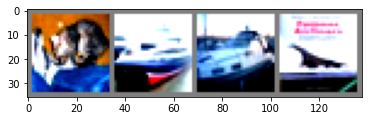

In [15]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images[:4]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [16]:
outputs = model(images.to(device))

The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [17]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship  ship


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [18]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 87 %


That looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [19]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 89 %
Accuracy of   car : 96 %
Accuracy of  bird : 79 %
Accuracy of   cat : 71 %
Accuracy of  deer : 85 %
Accuracy of   dog : 80 %
Accuracy of  frog : 92 %
Accuracy of horse : 91 %
Accuracy of  ship : 93 %
Accuracy of truck : 92 %
